# A Beginner’s Guide to Carry out Extreme Value Analysis (with Codes in Python)

## 1. Load precipitation data

Pandas has dedicated libraries for handling time series(TS) objects. Lets start by firing up the required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Load the data set and look at some initial rows and data types of the columns:

In [2]:
data = pd.read_csv('fortprec.txt', sep ='\t')
print data.tail()
print '\n Data Types:'
print data.dtypes

         obs  tobs  month  day  year  Prec
36520  36520   361     12   27  1999   0.0
36521  36521   362     12   28  1999   0.0
36522  36522   363     12   29  1999   0.0
36523  36523   364     12   30  1999   0.0
36524  36524   365     12   31  1999   0.0

 Data Types:
obs        int64
tobs       int64
month      int64
day        int64
year       int64
Prec     float64
dtype: object


## 2. EVA Analysis

The Python version of L-moments is used to predict optimal parameters for a number of distributions (https://pypi.python.org/pypi/lmoments/). 

Distributions supported are listed below, with their distribution suffix:
* Exponential (EXP)
* Gamma (GAM)
* Generalised Extreme Value (GEV)
* Generalised Logistic (GLO)
* Generalised Normal (GNO)
* Generalised Pareto (GPA)
* Gumbel (GUM)
* Kappa (KAP)
* Normal (NOR)
* Pearson III (PE3)
* Wakeby (WAK)
* Weibull (WEI)
    
lmoments can be installed by one of them:
 * conda install lmoments
 * pip install lmoments
 
 
As a demo, several distribution are used here.

### Import lmoments to carry out  EVA analysis

In [3]:
import lmoments

### Select annual maxima as extreme values

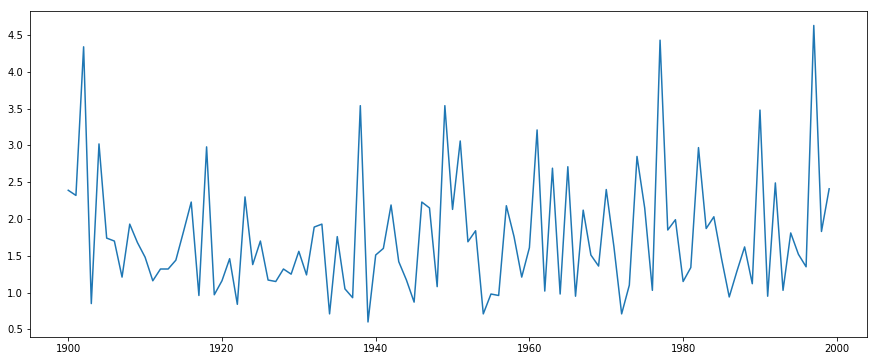

In [4]:
df = data.groupby("year").Prec.max()
plt.plot(df)

### Calculate L-moments

In [5]:
LMU = lmoments.samlmu(df)
LMU

[1.7567000000000004,
 0.44195050505050509,
 0.25633024533445298,
 0.1591798979081134,
 0.080687986025102965]

### Fit GEV distribution (i.e., parameter pstimation)

In [6]:
gevfit = lmoments.pelgev(LMU)
expfit = lmoments.pelexp(LMU)
gumfit = lmoments.pelgum(LMU)
weifit = lmoments.pelwei(LMU)
gpafit = lmoments.pelgpa(LMU)
pe3fit = lmoments.pelpe3(LMU)
gamfit = lmoments.pelgam(LMU)
glofit = lmoments.pelglo(LMU)

### Get extreme precipitation according to some return years

In [7]:
# return years (1.1 to 1000)
T = np.arange(0.1, 999.1, 0.1) + 1

# extreme precipitations
gevST = lmoments.quagev(1.0-1./T, gevfit)
expST = lmoments.quaexp(1.0-1./T, expfit)  
gumST = lmoments.quagum(1.0-1./T, gumfit)
weiST = lmoments.quawei(1.0-1./T, weifit)
gpaST = lmoments.quagpa(1.0-1./T, gpafit)
pe3ST = lmoments.quape3(1.0-1./T, pe3fit)
gamST = lmoments.quagam(1.0-1./T, gamfit)
gloST = lmoments.quaglo(1.0-1./T, glofit)

lmoments\_otherfunct.py:9: RuntimeWarning: invalid value encountered in double_scalars
  obj+obj, obj-obj, obj*obj, obj**obj, obj/obj


### Compare with empirical distribution

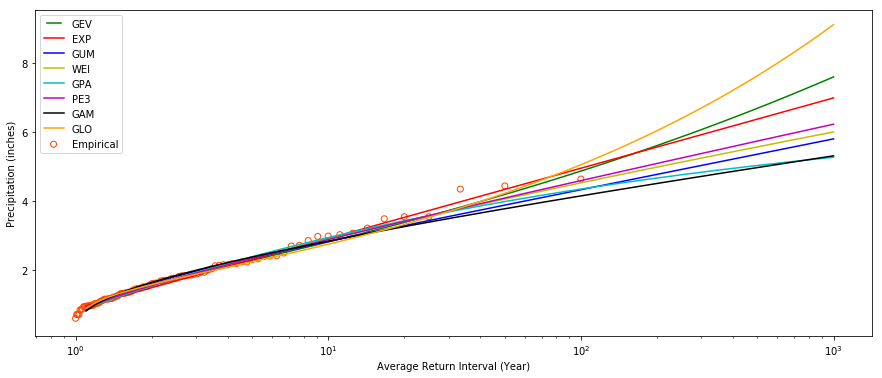

In [8]:
# setup plotting parameters
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('Precipitation (inches)')

# draw extreme values from GEV distribution
line1, = plt.plot(T, gevST, 'g', label='GEV')
line2, = plt.plot(T, expST, 'r', label='EXP')
line3, = plt.plot(T, gumST, 'b', label='GUM')
line4, = plt.plot(T, weiST, 'y', label='WEI')
line5, = plt.plot(T, gpaST, 'c', label='GPA')
line6, = plt.plot(T, pe3ST, 'm', label='PE3')
line7, = plt.plot(T, gamST, 'k', label='GAM')
line8, = plt.plot(T, gloST, c='orange', label='GLO')

# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color = 'orangered', facecolors='none', label='Empirical')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

## Select an Optimal Distribution 

There are several tests aviable to select the best distributons. Here we used the Kolmogorov-Smirnov(KS) test, which is available in scipy.stats.ks_2samp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

* Parameters:	
data1, data2 : sequence of 1-D ndarrays
two arrays of sample observations assumed to be drawn from a continuous distribution, sample sizes can be different
* Returns:	
statistic : float
KS statistic
pvalue : float
two-tailed p-value

Note:
If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [9]:
from scipy import stats as stats

In [10]:
# prepare probabilites according to observations
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)   
P0   = (N-1.)/Nmax
P    = np.delete(P0,0)

obs = sorted(df)[1:]

# extreme precipitations
gevSTo = lmoments.quagev(P, gevfit)
expSTo = lmoments.quaexp(P, expfit)  
gumSTo = lmoments.quagum(P, gumfit)
weiSTo = lmoments.quawei(P, weifit)
gpaSTo = lmoments.quagpa(P, gpafit)
pe3STo = lmoments.quape3(P, pe3fit)
gamSTo = lmoments.quagam(P, gamfit)
gloSTo = lmoments.quaglo(P, glofit)

# do ks test
ks = [('GEV', stats.ks_2samp(obs, gevSTo)), ('EXP', stats.ks_2samp(obs, expSTo)),
      ('GUM', stats.ks_2samp(obs, gumSTo)), ('WEI', stats.ks_2samp(obs, weiSTo)),
      ('GPA', stats.ks_2samp(obs, gpaSTo)), ('PE3', stats.ks_2samp(obs, pe3STo)), 
      ('GAM', stats.ks_2samp(obs, gamSTo)), ('GLO', stats.ks_2samp(obs, gloSTo))]

labels = ['Distribution', 'KS (statistics, pvalue)']
pd.DataFrame(ks, columns=labels)

,Distribution,"KS (statistics, pvalue)"
0,GEV,"(0.040404040404, 0.999996409832)"
1,EXP,"(0.0707070707071, 0.959249959547)"
2,GUM,"(0.0606060606061, 0.991594683678)"
3,WEI,"(0.0505050505051, 0.999430218228)"
4,GPA,"(0.0505050505051, 0.999430218228)"
5,PE3,"(0.0505050505051, 0.999430218228)"
6,GAM,"(0.0707070707071, 0.959249959547)"
7,GLO,"(0.0505050505051, 0.999430218228)"


#### It can be found that thses distributions have very similary performance. However, GEV gets the champion with minimum statistics and maximum pvalue. So redraw the plot based on the selected GEV distribution.

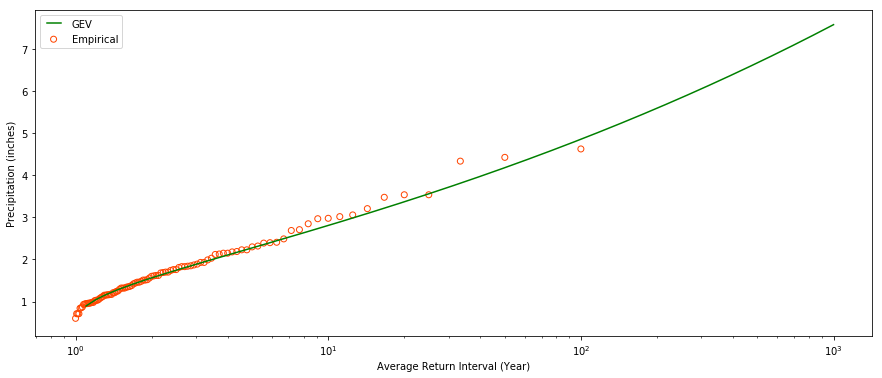

In [11]:
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('Precipitation (inches)')
line1, = plt.plot(T, gevST, 'g', label='GEV')

# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color = 'orangered', facecolors='none', label='Empirical')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

## End Notes

Through this guide I have tried to give you a basic idea how to carry out extreme value analysis (EVA) upon a time series data of interest.

In fact, the analysis will become more complicated in a real practice as high quality data are not always available. Sometimes, you have to spend a lot of time cleaning the data. For example, fill the missing values and check outliers.

In addition, carrying out EVA always fits several distributions, simultaneouly. Then a goodness-of-fit measure (e.g., Anderson-Darling test) is used to select the optimal one.

This is just a start. You can try more.
